
## Random Forest Overfitting: Under what circumstances does it occur?

#### Agustin Garbino
#### Petroleum Engineering Department, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

The following project was developed to understand if a Random Forest model could be overfitted. To this purpose, this algorithm was tested for different samples with increasing noise levels, number of features and and model complexity. It was observed that Random Forest overfitting is indeed possible under high noise levels, and that it is not excesively affected by increasing the number of features, at least for the tested dataset. Based on the results, it is recommended to test in all cases the out-of-bag variance explained to tune hyperparameters and avoid model overfitting.


### Import Packages

In [1]:
import numpy as np                                        # for working with data and model arrays
import pandas as pd                                       # DataFrames and plotting
import matplotlib.pyplot as plt                           # plotting
import warnings                                           # supress any warnings for this demonstration
warnings.filterwarnings('ignore')    
cmap = plt.cm.inferno                                     # default color bar, no bias and friendly for color vision defeciency
import math                                               # basic calculations like square root
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn.ensemble import RandomForestRegressor        # random forest method
from sklearn import metrics                               # measures to check our models


### Functions

The following functions will be used in the workflow.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_EnsembleTrees.ipynb).

In [2]:
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    cmap = plt.cm.inferno
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    im = plt.imshow(Z,interpolation = None,aspect = "auto",extent = [x_min,x_max,y_min,y_max], vmin = z_min, vmax = z_max,cmap = cmap)
    if (type(xfeature) != str) & (type(yfeature) != str):
        plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=1.0, linewidths=0.6, edgecolors="white")
        plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    else:
        plt.xlabel(xfeature); plt.ylabel(yfeature)
    plt.title(title)                                       # add the labels

    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    if type(response) == str:
        cbar.set_label(response, rotation=270, labelpad=20)        
    else:
        cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=cmap, norm=None, vmin=None, vmax=None, alpha=0.2,     linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))
    

### Load Data

The following workflow applies the .csv file 'unconv_MV_v5.csv', a synthetic dataset. The dataset is publically available in: (https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv)  

We will work with the following features:

* **porosity** - fraction of rock void in units of percentage
* **permeability** - ability of a fluid to flow through the rock in mil;iDarcy
* **acoustic impedence** - product of sonic velocity and rock density in units of $kg/m^2s*10^3$
* **brittleness** - tendency of the rock to break in units of $um^(-0.5)$
* **TOC** - total organic coarbon in the rock in units of $mg/L C$
* **vitrinite reflectance** - proportion of incident light reflected from a polished vitrinite surface in units of $Ro$ 


In [3]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv") # load the data from my github repo

yname = 'Production'; Xname_2_features = ['Por','Brittle']           # specify the predictor features (x2) and response feature (x1)
df = df.rename(columns={"Prod": "Production"})

predictors_2_features = df[['Por','Brittle']].copy()                # define a set of predictor features with only 2 features

n_cols = 6
predictors_n_features = df.iloc[:, range(1, n_cols+1)]              # define a set of predictor features with only 2 features

### Random Forest Overfitting

1. Adding noise to the data

2. Comparison of Low vs High Noise response features with varying model complexity

3. Variance Explained with increasing noise and complexity (2 features)

4. Variance Explained with increasing noise and complexity (6 features)

5. Random Forest vs Bagging: Variance Explained with increasing noise and complexity (6 features)


### 1. Adding noise to the data

Since it is inteded to test the impact of noise in the response feature on the Random Forest algorithm, two datasets are defined initially with varying levels of noise. The variable used to change the noise level is the standar deviation of the normal distribution that adds noise to the data. The data with low and high levels of noise are the plotted for validation.


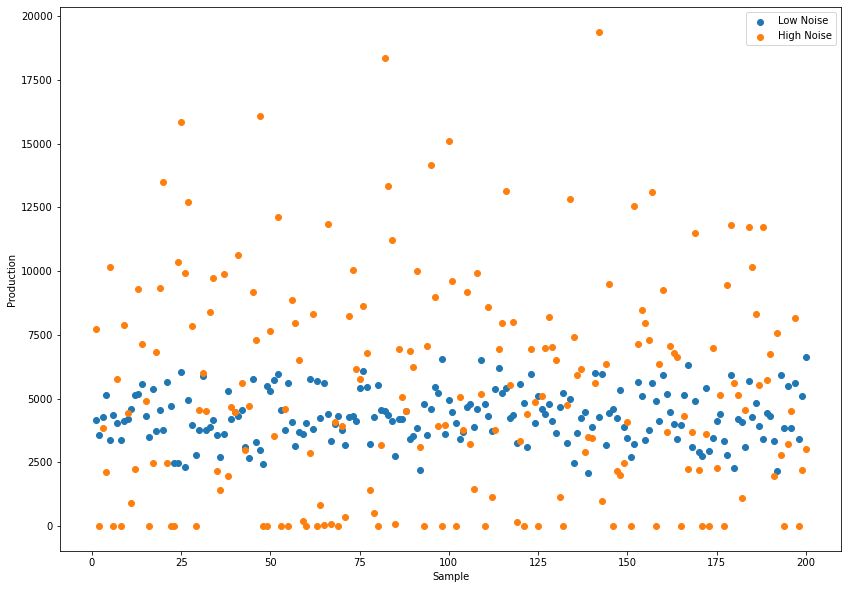

In [36]:
#Setting Random Seed for Adding Noise
seed = 71071
np.random.seed(seed=seed)                                                     # set random number seed

#Defining Dataset with a low level of noise
std_error_low = 50                                                            #set level of noise
df_low_noise = df.copy()
df_low_noise[yname] = df[yname] + np.random.normal(loc = 0.0,scale=std_error_low,size=len(df)) # add noise

y_low_noise = pd.DataFrame(df_low_noise[yname])                               # extract selected features as X and y DataFrames
df_low_noise = pd.concat([predictors_n_features,y_low_noise],axis=1)          # make one DataFrame with both X and y (remove all other features)
df_low_noise[yname][df_low_noise[yname] < 0] = 0                              # negative production values are set to 0

#Defining Dataset with a high level of noise
std_error_high = 5000                                                         #set level of noise
df_high_noise = df.copy()
df_high_noise[yname] = df[yname] + np.random.normal(loc = 0.0,scale=std_error_high,size=len(df)) # add noise

y_high_noise = pd.DataFrame(df_high_noise[yname])                             # extract selected features as X and y DataFrames
df_high_noise = pd.concat([predictors_n_features,y_high_noise],axis=1)        # make one DataFrame with both X and y (remove all other features)
df_high_noise[yname][df_high_noise[yname] < 0] = 0                            # negative production values are set to 0

#Plotting the response feature
fig, ax = plt.subplots(1,1, figsize = (14,10))
ax.scatter(np.linspace(1,len(df), len(df)), df_low_noise[yname], label = 'Low Noise')
ax.scatter(np.linspace(1,len(df), len(df)), df_high_noise[yname] , label = 'High Noise')
ax.set_ylabel('Production')
ax.set_xlabel('Sample')
ax.legend()

### 2. Comparison of Low vs High Noise response features with varying model complexity

The Random Forest algorithm is tested with the low-noise and high-noise datasets. The complexity of the model is varied to test the results for:

- 2.1 Low complexity model 
- 2.2 High complexity model

In this case, only two features are used in the analysis to ease visualization: Porosity and Brittleness

Results of the predicted model compared to the actual Production values are analyzed using two plots: a colormap that represents the value of the response feature; and a crossplot in which the deviation from a straight line indicated higher model error.


#### 2.1 Comparison of Low vs High Noise response features - Low model complexity


A less complex model is tested. It is defined by the following hyperparameters:

- maximum depth of each individual tree is set to 7
- number of trees is set to 300

Mean Squared Error on Training =  13250.92 , Variance Explained = 0.99 Cor = 0.99
Mean Squared Error on Training =  8123289.19 , Variance Explained = 0.54 Cor = 0.73


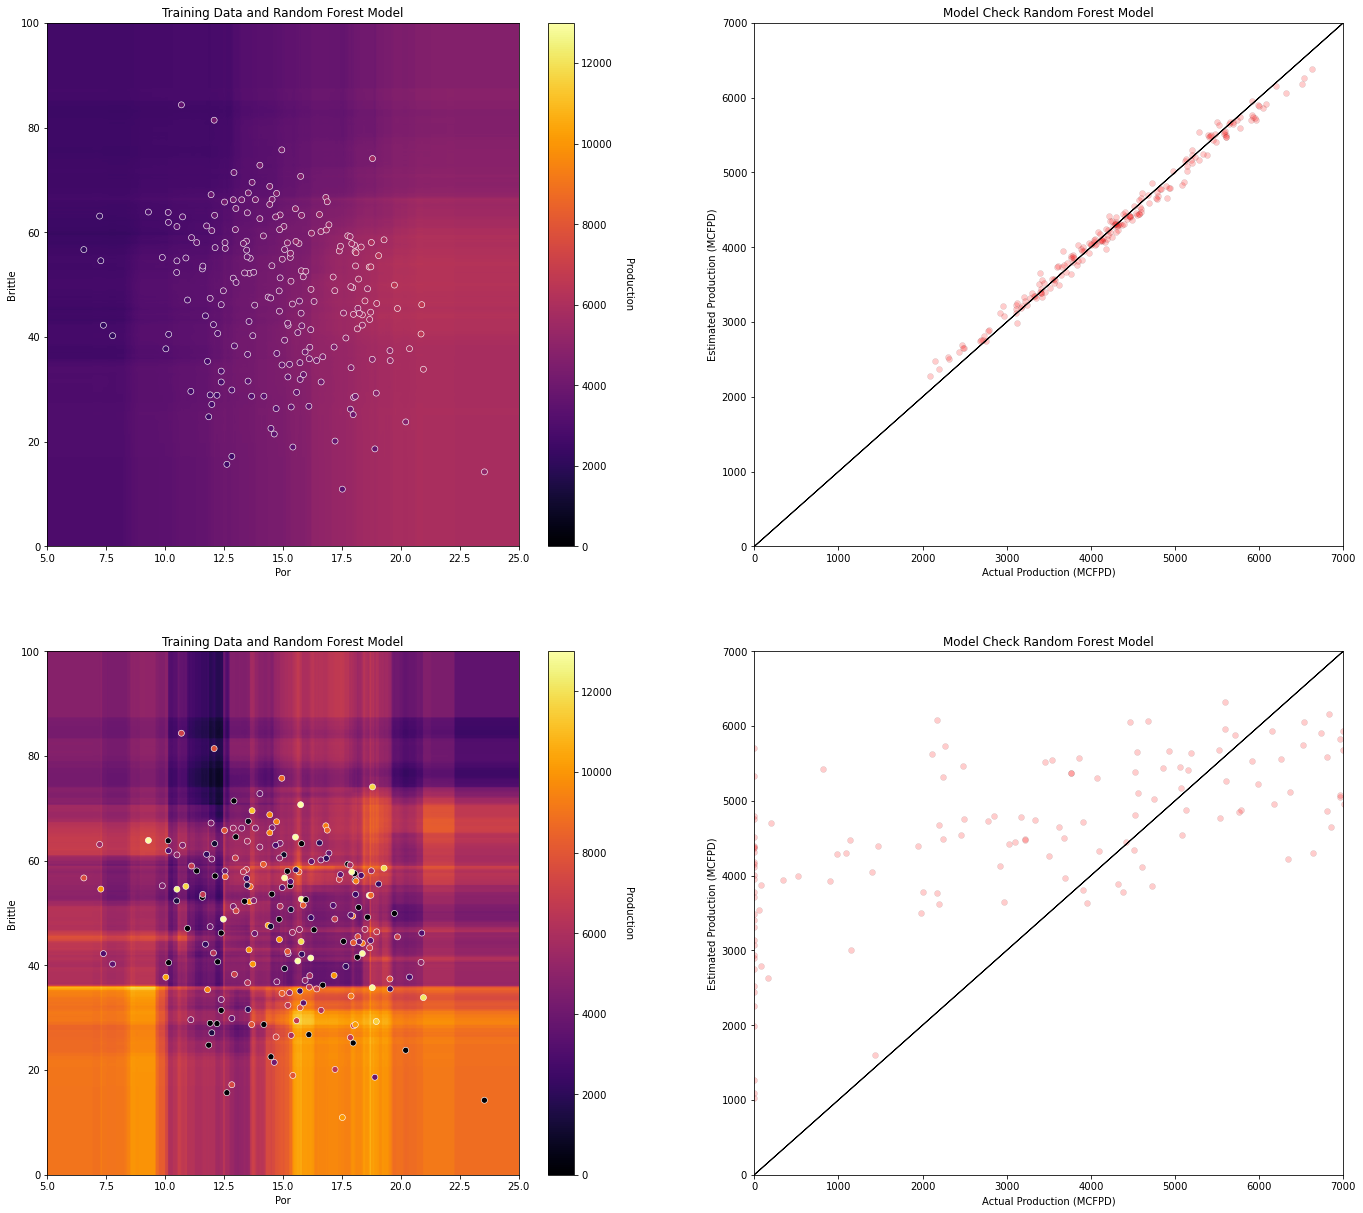

In [34]:
#The following code was inspired by the notebook SubSurfuceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub], previously referenced

pormin = 5.0; pormax = 25.0                                 # set minumums and maximums for visualization 
brittlemin = 0.0; brittlemax = 100.0
prodmin = 0.0; prodmax = 13000.0

seed = 73093                                                # set the random forest hyperparameters
max_depth = 7
num_tree = 300
max_features = 1

#Low Noise
response_low_noise = df_low_noise[yname]                    # define response feature 

low_noise_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)  #instantiate the model

low_noise_forest.fit(X = predictors_2_features, y = response_low_noise)           # train the model with training data 

#High Noise
response_high_noise = df_high_noise[yname]                   # define response feature

high_noise_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)

high_noise_forest.fit(X = predictors_2_features, y = response_high_noise)           # train the model with training data 


#Plotting
plt.subplot(221)                                            # predict with the model over the predictor feature space and visualize
visualize_model(low_noise_forest,df["Por"],pormin,pormax,df["Brittle"],brittlemin,brittlemax,df_low_noise["Production"],prodmin,prodmax,'Training Data and Random Forest Model')

plt.subplot(222)                                            # perform cross validation with withheld testing data
check_model(low_noise_forest,df["Por"],df["Brittle"],df_low_noise["Production"],'Model Check Random Forest Model')

plt.subplot(223)                                            # predict with the model over the predictor feature space and visualize
visualize_model(high_noise_forest,df["Por"],pormin,pormax,df["Brittle"],brittlemin,brittlemax,df_high_noise["Production"],prodmin,prodmax,'Training Data and Random Forest Model')

plt.subplot(224)                                            # perform cross validation with withheld testing data
check_model(high_noise_forest,df["Por"],df["Brittle"],df_high_noise["Production"],'Model Check Random Forest Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=4.0, wspace=0.2, hspace=0.2)


It can be observed that while the model is continuous and smooth for the case of the data with a low noise level, it is exceedingly discontinuous and shows abrupt jumps when using a more noisy dataset. The plots on the right also evidence a worse fit from the model on the case of a more noisy dataset. The variance explained by the model is only 0.54 in the noisier dataset.

#### 2.2 Comparison of Low vs High Noise response features - High model complexity


A less complex model is tested. It is defined by the following hyperparameters:

- maximum depth of each individual tree is set to 300
- number of trees is set to 600

Since only 2 features are being analyzed, the maximum number of features for splitting is set to 1

Mean Squared Error on Training =  7548.53 , Variance Explained = 0.99 Cor = 1.0
Mean Squared Error on Training =  2967353.74 , Variance Explained = 0.83 Cor = 0.91


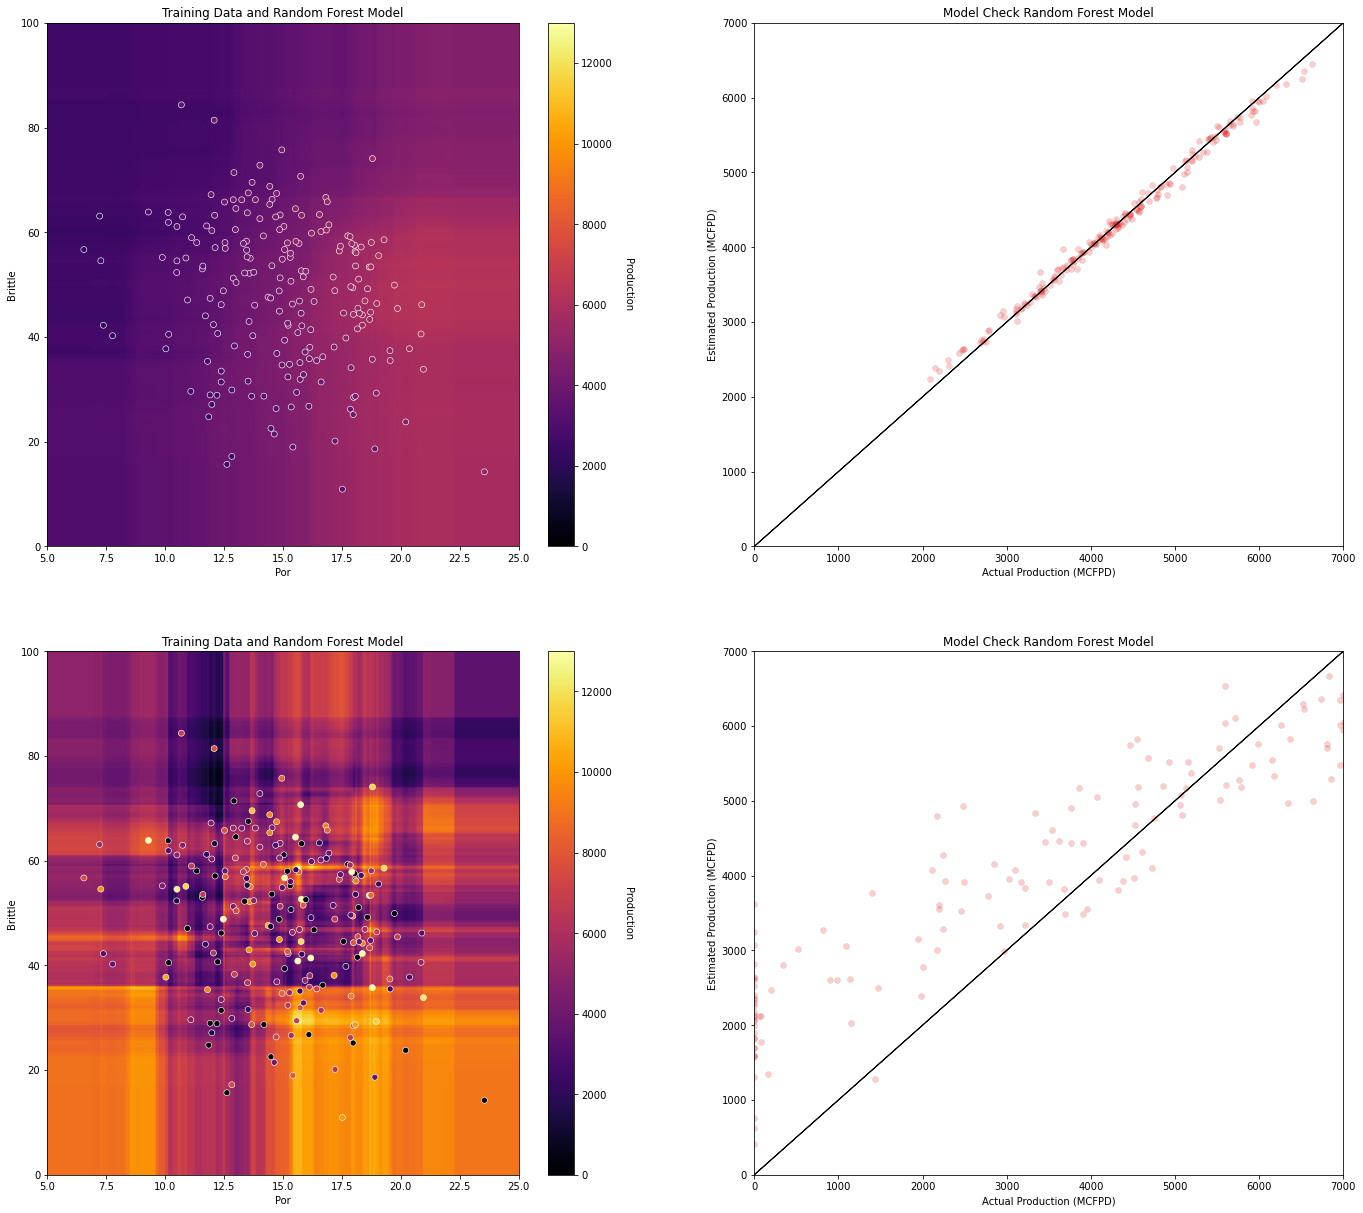

In [17]:
seed = 73093                                                # set the random forest hyperparameters
max_depth = 300
num_tree = 600
max_features = 1

#Low Noise
response_low_noise = df_low_noise[yname]                    # define response feature 
low_noise_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)

low_noise_forest.fit(X = predictors_2_features, y = response_low_noise)           # train the model with training data 

#High Noise
response_high_noise = df_high_noise[yname]                    # define response feature 
high_noise_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)

high_noise_forest.fit(X = predictors_2_features, y = response_high_noise)           # train the model with training data 

#Plotting
plt.subplot(221)                                            # predict with the model over the predictor feature space and visualize
visualize_model(low_noise_forest,df["Por"],pormin,pormax,df["Brittle"],brittlemin,brittlemax,df_low_noise["Production"],prodmin,prodmax,'Training Data and Random Forest Model')

plt.subplot(222)                                            # perform cross validation with withheld testing data
check_model(low_noise_forest,df["Por"],df["Brittle"],df_low_noise["Production"],'Model Check Random Forest Model')

plt.subplot(223)                                            # predict with the model over the predictor feature space and visualize
visualize_model(high_noise_forest,df["Por"],pormin,pormax,df["Brittle"],brittlemin,brittlemax,df_high_noise["Production"],prodmin,prodmax,'Training Data and Random Forest Model')

plt.subplot(224)                                            # perform cross validation with withheld testing data
check_model(high_noise_forest,df["Por"],df["Brittle"],df_high_noise["Production"],'Model Check Random Forest Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=4.0, wspace=0.2, hspace=0.2)


The behavior previously observed is replicated in this case. While the more complex model is still continuous and smooth in the case of less noisy data, it is highly discontinuous when using a more noisy dataset. The overall model error evidenced by the deviation of points from the straight line dropped in the case of the noisier dataset, and variance explained is now 0.83. 

With these results it is still not possible to state if there is model overfitting occuring, but they are a good start to understand that Random Forest can produce discontinuous and complex models with noisy datasets.

### 3. Variance Explained with increasing noise and complexity (2 predictor features)

To better understand the ocurrence of model overfitting, a sensitivity was carried out for the testing error as model complexity increases against different datasets with varying levels of noise. The testing error was analyzed via the variance explained by the out of bag score in the Random Forest algorithm, which evaluates the error at the points that were not sapled during bootstrap. 

This analysis was done using only two features in this case: Porosity and Brittleness. Later on, the number of features was increased to test how this impacts model fitting.

To vary model complexity, the following hyperparameters were analyzed individually at wide ranges of values:

- maximum depth of each individual tree: 1 to 200
- number of trees: 2 to 200

Noise levels were increased varying the standard deviation of the normal distribution in the following range:

- std deviation: 50 to 5000

Since only 2 features are being analyzed, the maximum number of features for splitting is set to 1

Results are visualized in crossplots of out-of-bag variance explained versus increasing model complexity at different noise levels

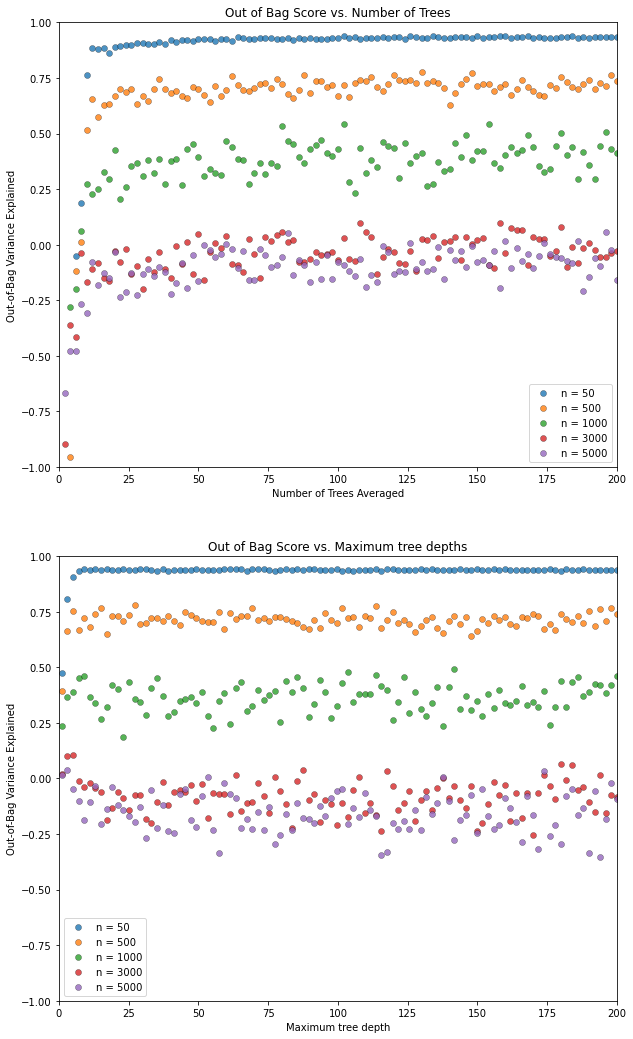

In [38]:
#The following code was inspired by the notebook SubSurfuceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub], previously referenced

predictors = predictors_2_features                         # define predictor features
noises = [50, 500, 1000, 3000, 5000]                       # range of standard deviation values to modify noise levels

# Testing number of trees hyperparameter
max_depth = 7                                              # set the random forest hyperparameters
num_treess = np.linspace(2,200,100)
max_features = 1                                           # maximum number of features to select for splitting at each step in an individual tree
fit_forests = []                                           # define auxiliary variable

index = 1
oob_MSE_trees = [ [] for i in range(len(noises)) ]

for n in range(len(noises)):
    for num_tree in num_treess:                                 # loop over number of trees in our random forest
        response = df['Production'] + np.random.normal(loc = 0.0,scale=noises[n],size=len(df)) # add noise
        fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
        fit_forests[index-1].fit(X = predictors, y = response)
        oob_MSE_trees[n].append(fit_forests[index-1].oob_score_)
        index = index + 1
    
    
# Testing maximum depth at each tree hyperparameter
max_depths = np.linspace(1,200,100)                          # set the tree maximum tree depths to consider                                          
num_trees = 50
max_features = 1                                             # maximum number of features to select for splitting at each step in an individual tree
fit_forests = []                                             #define auxiliary variable

index = 1

oob_MSE_depths = [ [] for i in range(len(noises)) ]

for n in range(len(noises)):
    for max_depth in max_depths:                                 # loop over number of trees in our random forest
        response = df['Production'] + np.random.normal(loc = 0.0,scale=noises[n],size=len(df)) # add noise
        fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
        fit_forests[index-1].fit(X = predictors, y = response)
        oob_MSE_depths[n].append(fit_forests[index-1].oob_score_)
        index = index + 1
        

# Plotting results      
fig, ax = plt.subplots(2,1 , figsize = (10,18))

#Number of Trees Sensitivity
for n in range(len(noises)):
    ax[0].scatter(num_treess,oob_MSE_trees[n],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'n = %i' %(noises[n]))

ax[0].set_title('Out of Bag Score vs. Number of Trees'); ax[0].set_xlabel('Number of Trees Averaged'); ax[0].set_ylabel('Out-of-Bag Variance Explained')
ax[0].set_xlim(0,200); ax[0].set_ylim(-1,1.0)
ax[0].legend(loc = 'best')

#Max Depth Sensitivity
for n in range(len(noises)):
    ax[1].scatter(max_depths,oob_MSE_depths[n],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'n = %i' %(noises[n]))

ax[1].set_title('Out of Bag Score vs. Maximum tree depths'); ax[1].set_xlabel('Maximum tree depth'); ax[1].set_ylabel('Out-of-Bag Variance Explained')
ax[1].set_xlim(0,200); ax[1].set_ylim(-1,1.0)

ax[1].legend(loc = 'best')

Results evidence that at increasing levels of noise, the variance explained by the model is reduced. It can be noted that at low noise levels, the model behaves robustly and does not become overfitted. However, with increasing noise, the model becomes more unstable and cycles of increasing and decreasing variance explained are observed with increasing model complaxity. Despite this, the trend itself is stable in most cases. Hoswever, in the bottom plot, at the highest noise levels tested, the variance explained is clearly reduced after increasing the maximum tree depth, evidencing an overfitting behavior of the model.

### 4. Variance Explained with increasing noise and complexity (6 predictor features)

The previous step is repeated, but in this case all available features in the dataset are used as predictor features to train the Random Forest model. The sensitivity of the hyperparameters and noise in the response feature remains the same.


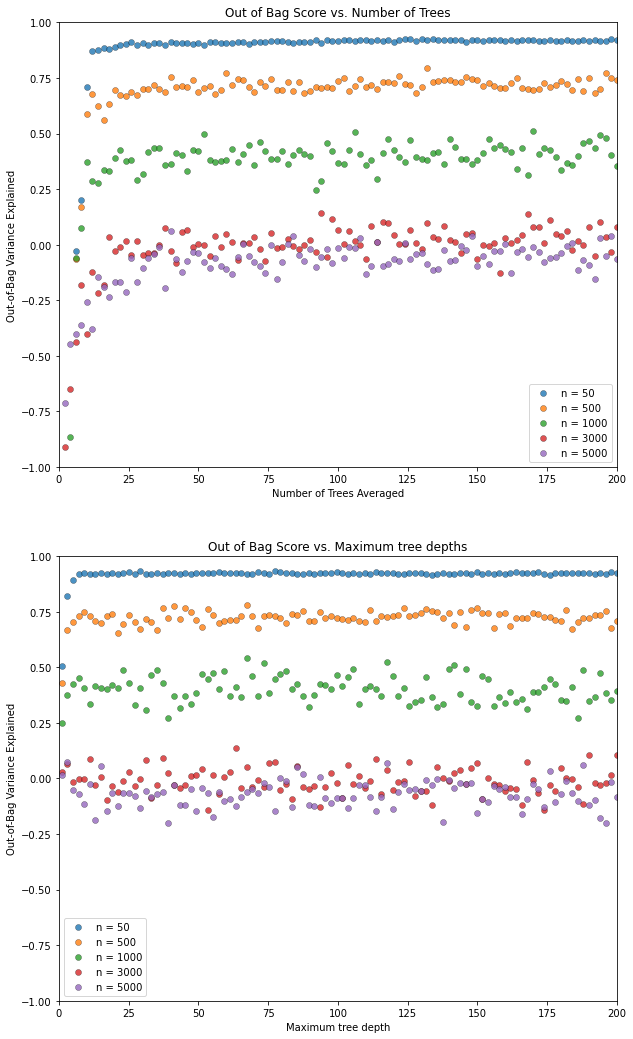

In [39]:
predictors = predictors_n_features                         #define predictor features
noises = [50, 500, 1000, 3000, 5000]                       #range of standard deviation values to modify noise levels

# Testing number of trees hyperparameter
max_depth = 7                                              # set the random forest hyperparameters
num_treess_n = np.linspace(2,200,100)                      
max_features = 2                                           # maximum number of features to select for splitting at each step in an individual tree
fit_forests = []

index = 1
oob_MSE_trees_n = [ [] for i in range(len(noises)) ]

for n in range(len(noises)):
    for num_tree in num_treess_n:                           # loop over number of trees in our random forest
        response = df['Production'] + np.random.normal(loc = 0.0,scale=noises[n],size=len(df)) # add noise
        
        fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
        fit_forests[index-1].fit(X = predictors, y = response)
        oob_MSE_trees_n[n].append(fit_forests[index-1].oob_score_)
        index = index + 1

        
# Testing maximum depth at each tree hyperparameter        
max_depths_n = np.linspace(1,200,100)                        # set the tree maximum tree depths to consider                                          
num_trees = 50
max_features = 2                                             # maximum number of features to select for splitting at each step in an individual tree
fit_forests = []

index = 1
oob_MSE_depths_n = [ [] for i in range(len(noises)) ]

for n in range(len(noises)):
    for max_depth in max_depths_n:                           # loop over number of trees in our random forest
        response = df['Production'] + np.random.normal(loc = 0.0,scale=noises[n],size=len(df)) # add noise
        
        fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
        fit_forests[index-1].fit(X = predictors, y = response)
        oob_MSE_depths_n[n].append(fit_forests[index-1].oob_score_)
        index = index + 1
    

# Plotting results
fig, ax = plt.subplots(2,1 , figsize = (10,18))

# Number of Trees Sensitivity
for n in range(len(noises)):
    ax[0].scatter(num_treess_n,oob_MSE_trees_n[n],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'n = %i' %(noises[n]))

ax[0].set_title('Out of Bag Score vs. Number of Trees'); ax[0].set_xlabel('Number of Trees Averaged'); ax[0].set_ylabel('Out-of-Bag Variance Explained')
ax[0].set_xlim(0,200); ax[0].set_ylim(-1,1.0)
ax[0].legend(loc = 'best')

#Max Depth Sensitivity
for n in range(len(noises)):
    ax[1].scatter(max_depths_n,oob_MSE_depths_n[n],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'n = %i' %(noises[n]))

ax[1].set_title('Out of Bag Score vs. Maximum tree depths'); ax[1].set_xlabel('Maximum tree depth'); ax[1].set_ylabel('Out-of-Bag Variance Explained')
ax[1].set_xlim(0,200); ax[1].set_ylim(-1,1.0)

ax[1].legend(loc = 'best')


Results obtained are similar to the previous case. At increasing levels of noise, the variance explained by the model is reduced. The same robustness shown by the model when handling low levels of noise is evidenced in this case, while the unstable cycles of increasing and decreasing variance explained remain present with increasing model complexity at noisy datasets. The main difference when comparing with the previous case is that when using 6 predictor features, the initial fall for variance explained that was seen in the case with 2 predictor features is more subtle than before.

### 5. Random Forest vs Bagging: Variance Explained with increasing noise and complexity (6 features)

The previous step is repeated keeping the number of predictor features to train the Random Forest model at 6. However, in this case the maximum number of features for splitting is set to 6. By doing this, the algorithm becomes Bagging instead of Random Forest. The main goal is to test the differences between both algorithms when dealing with different levels of noise present in the data with increasing model complexity.

The sensitivity of the hyperparameters and noise in the response feature remains the same.



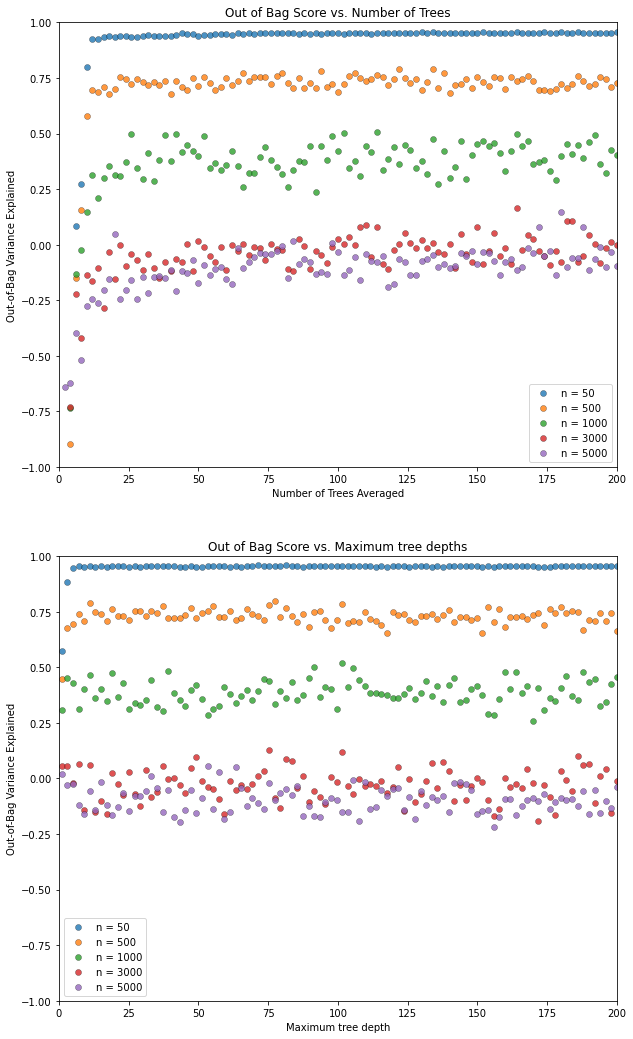

In [40]:
predictors = predictors_n_features                         #define predictor features
noises = [50, 500, 1000, 3000, 5000]                       #range of standard deviation values to modify noise levels

# Testing number of trees hyperparameter
max_depth = 7                                              # set the random forest hyperparameters
num_treess_bag = np.linspace(2,200,100)
max_features = 6                                           # maximum number of features to select for splitting at each step in an individual tree
fit_forests = []

index = 1
oob_MSE_trees_bag = [ [] for i in range(len(noises)) ]

for n in range(len(noises)):
    for num_tree in num_treess_bag:                              # loop over number of trees in our random forest
        response = df['Production'] + np.random.normal(loc = 0.0,scale=noises[n],size=len(df)) # add noise
        
        fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
        fit_forests[index-1].fit(X = predictors, y = response)
        oob_MSE_trees_bag[n].append(fit_forests[index-1].oob_score_)
        index = index + 1
    
# Testing maximum depth at each tree hyperparameter   
max_depths_bag = np.linspace(1,200,100)                          # set the tree maximum tree depths to consider                                          
num_trees = 50
max_features = 6                                                 # maximum number of features to select for splitting at each step in an individual tree
fit_forests = []

index = 1
oob_MSE_depths_bag = [ [] for i in range(len(noises)) ]

for n in range(len(noises)):
    for max_depth in max_depths_bag:                              # loop over number of trees in our random forest
        response = df['Production'] + np.random.normal(loc = 0.0,scale=noises[n],size=len(df)) # add noise
        
        fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
        fit_forests[index-1].fit(X = predictors, y = response)
        oob_MSE_depths_bag[n].append(fit_forests[index-1].oob_score_)
        index = index + 1
        

#Plotting results
fig, ax = plt.subplots(2,1 , figsize = (10,18))

# Number of Trees Sensitivity
for n in range(len(noises)):
    ax[0].scatter(num_treess_bag,oob_MSE_trees_bag[n],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'n = %i' %(noises[n]))

ax[0].set_title('Out of Bag Score vs. Number of Trees'); ax[0].set_xlabel('Number of Trees Averaged'); ax[0].set_ylabel('Out-of-Bag Variance Explained')
ax[0].set_xlim(0,200); ax[0].set_ylim(-1,1.0)
ax[0].legend(loc = 'best')

#Max Depth Sensitivity
for n in range(len(noises)):
    ax[1].scatter(max_depths_bag,oob_MSE_depths_bag[n],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'n = %i' %(noises[n]))

ax[1].set_title('Out of Bag Score vs. Maximum tree depths'); ax[1].set_xlabel('Maximum tree depth'); ax[1].set_ylabel('Out-of-Bag Variance Explained')
ax[1].set_xlim(0,200); ax[1].set_ylim(-1,1.0)
ax[1].legend(loc = 'best')


Once again, the same trends previously observed remain in this case. At increasing levels of noise, the variance explained by the model is reduced. It is interesting to note that the Bagging algorithm is also very robust when dealing with data that is not extremely noisy, while the unstable cycles of increasing and decreasing variance explained appear with increasing model complexity at noisy datasets. The behavior in general resembles the one exhibited by Random Forest

### Results

To better understand the results, the following plot was created to compare between all cases. This plot allows to observe the differences at increasing levels of noise and complexity between:

- Random Forest training with 2 predictor features vs training with 6 predictor features
- Random Forest vs Bagging training with 6 predictor features

The dahsed lines are an indication of the average values in the noisier datasets for the three different cases throughout the whole range of model complexities



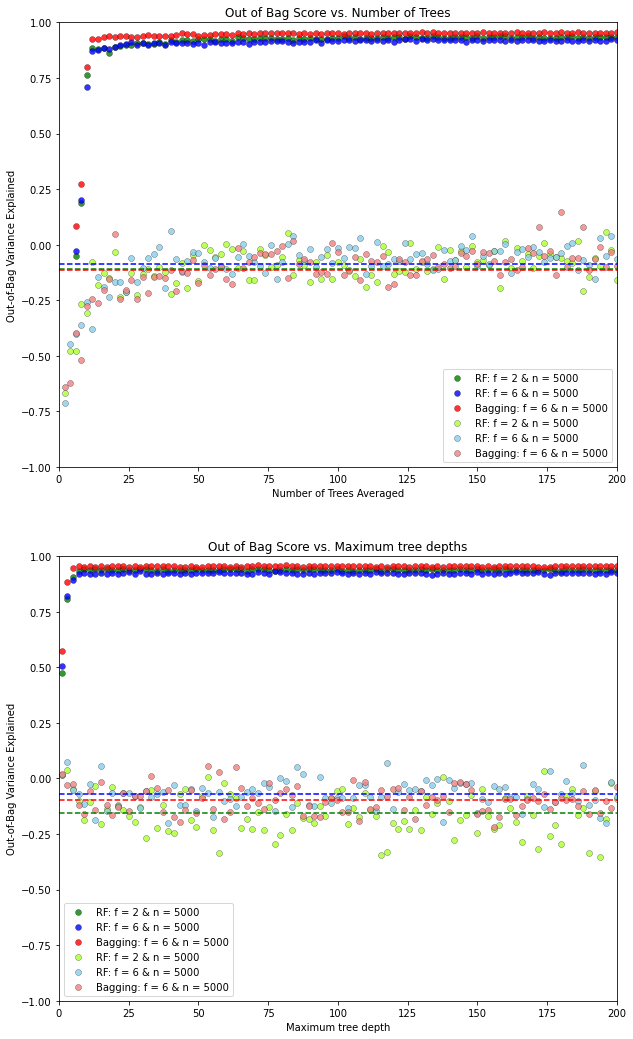

In [41]:
fig, ax = plt.subplots(2,1 , figsize = (10,18))

#Number of trees Plot
ax[0].scatter(num_treess,oob_MSE_trees[0],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 2 & n = %i' %(noises[n]), c='green')
ax[0].scatter(num_treess_n,oob_MSE_trees_n[0],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 6 & n = %i' %(noises[n]), c='blue')
ax[0].scatter(num_treess_bag,oob_MSE_trees_bag[0],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'Bagging: f = 6 & n = %i' %(noises[n]), c='red')

ax[0].scatter(num_treess,oob_MSE_trees[len(noises)-1],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 2 & n = %i' %(noises[n]), c='greenyellow')
ax[0].scatter(num_treess_n,oob_MSE_trees_n[len(noises)-1],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 6 & n = %i' %(noises[n]), c='skyblue')
ax[0].scatter(num_treess_bag,oob_MSE_trees_bag[len(noises)-1],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'Bagging: f = 6 & n = %i' %(noises[n]), c='lightcoral')
    
ax[0].set_title('Out of Bag Score vs. Number of Trees'); ax[0].set_xlabel('Number of Trees Averaged'); ax[0].set_ylabel('Out-of-Bag Variance Explained')
ax[0].set_xlim(0,200); ax[0].set_ylim(-1,1.0)
ax[0].legend(loc = 'best')

ax[0].plot([0, max(num_treess)], np.ones(2)*np.average(oob_MSE_trees[len(noises)-1]), linestyle = '--', c='green')
ax[0].plot([0, max(num_treess_n)], np.ones(2)*np.average(oob_MSE_trees_n[len(noises)-1]), linestyle = '--', c='blue')
ax[0].plot([0, max(num_treess_bag)], np.ones(2)*np.average(oob_MSE_trees_bag[len(noises)-1]), linestyle = '--', c='red')


#Maximum Tree depth Plot
ax[1].scatter(max_depths,oob_MSE_depths[0],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 2 & n = %i' %(noises[n]), c='green')
ax[1].scatter(max_depths_n,oob_MSE_depths_n[0],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 6 & n = %i' %(noises[n]), c='blue')
ax[1].scatter(max_depths_bag,oob_MSE_depths_bag[0],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'Bagging: f = 6 & n = %i' %(noises[n]), c='red')

ax[1].scatter(max_depths,oob_MSE_depths[len(noises)-1],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 2 & n = %i' %(noises[n]), c='greenyellow')
ax[1].scatter(max_depths_n,oob_MSE_depths_n[len(noises)-1],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'RF: f = 6 & n = %i' %(noises[n]), c='skyblue')
ax[1].scatter(max_depths_bag,oob_MSE_depths_bag[len(noises)-1],s=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black" , label = 'Bagging: f = 6 & n = %i' %(noises[n]), c='lightcoral')

    
ax[1].set_title('Out of Bag Score vs. Maximum tree depths'); ax[1].set_xlabel('Maximum tree depth'); ax[1].set_ylabel('Out-of-Bag Variance Explained')
ax[1].set_xlim(0,200); ax[1].set_ylim(-1,1.0)
ax[1].legend(loc = 'best')

ax[1].plot([0, max(max_depths)], np.ones(2)*np.average(oob_MSE_depths[len(noises)-1]), linestyle = '--', c='green')
ax[1].plot([0, max(max_depths_n)], np.ones(2)*np.average(oob_MSE_depths_n[len(noises)-1]), linestyle = '--', c='blue')
ax[1].plot([0, max(max_depths_bag)], np.ones(2)*np.average(oob_MSE_depths_bag[len(noises)-1]), linestyle = '--', c='red')


The following conclusions can be made based on the results summarized in this plot:

- Variance explained is considerably reduced when training the model with increasing levels of noise in the response feature
- Bagging outperforms Random Forest when dealing with low noise levels (the first has higher variance explained)
- Random Forest is more robust than Bagging when handling more noisy datasets (the first has a higher average variance explained)
- Random Forest can be overfitted when trained with noisy datasets using high complexity hyperparameters, specially when increasing the maximum tree depth
- At least for this dataset, the variance explained by Random Forest using 6 predictor features instead of only 2 was enhanced and a better model can be obtained

### Parting Comments
* I am intereseted in any position related to Data Science, Data Analytics and Machine Learning in the Energy Industry. 

Contact Information: agarbino@utexas.edu 



I hope this was helpful,

*Agustin Garbino*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
